<a href="https://colab.research.google.com/github/schauppi/Udemy_TensorFlow_Developer/blob/main/Exam_preparation/oxford_flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prepare data

## Download dataset

In [1]:
#Import tensorflow datasets
import tensorflow_datasets as tfds
import tensorflow as tf

In [2]:
#List available datasets
datasets_list = tfds.list_builders()
#Check if dataset is available  
print("oxford_flowers102" in datasets_list)

True


In [3]:
#Load the data
(train_data, test_data, val_data), ds_info = tfds.load("oxford_flowers102",
                                                       split=["train", "test", "validation"],
                                                       shuffle_files=True,
                                                       as_supervised=True,
                                                       with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteVX1KMQ/oxford_flowers102-train.tfrecord


  0%|          | 0/1020 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteVX1KMQ/oxford_flowers102-test.tfrecord


  0%|          | 0/6149 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteVX1KMQ/oxford_flowers102-validation.tfrecord


  0%|          | 0/1020 [00:00<?, ? examples/s]

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [4]:
ds_info.features

FeaturesDict({
    'file_name': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=102),
})

In [5]:
#get class names
class_names = ds_info.features["label"].names
class_names[:10]

['pink primrose',
 'hard-leaved pocket orchid',
 'canterbury bells',
 'sweet pea',
 'english marigold',
 'tiger lily',
 'moon orchid',
 'bird of paradise',
 'monkshood',
 'globe thistle']

In [7]:
#Take one sample of the data
sample = train_data.take(1)
sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [8]:
# Output info about our training sample
for image, label in sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from tf_flowers (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (500, 666, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from tf_flowers (tensor form): 84
  Class name (str form): desert-rose
        


In [9]:
#Min an max values of image tensor
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

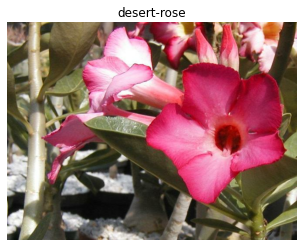

In [10]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

##Turn data into tf datasets

In [11]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [13]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

# Map prepreprocessing function to val data
val_data = val_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
val_data = val_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [14]:
train_data, val_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

# Modelling experiments

In [15]:
def plot_training_curve(history):
  plt.figure(figsize=(10,7))
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]
  plt.plot(loss, label="loss")
  plt.plot(val_loss, label="val_loss")
  plt.legend()
  plt.title("Loss")
  plt.figure(figsize=(10,7))
  plt.plot(accuracy, label="accuracy")
  plt.plot(val_accuracy, label="val_accuracy")
  plt.legend()
  plt.title("Accuracy")

## Model 0: CNN from scratch

In [35]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)

#Build the model 
inputs = layers.Input(shape=(224, 224, 3))
x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = layers.MaxPool2D((2,2))(x)
x = layers.Dropout(0.4)(x)
x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(inputs)
x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
x = layers.MaxPool2D((2,2))(x)
x = layers.Dropout(0.4)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)
model_0 = tf.keras.Model(inputs, outputs)

In [36]:
#Compile the model 
model_0.compile(loss="sparse_categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [37]:
#Fit the model 
history_model_0 = model_0.fit(train_data,
                              epochs=500,
                              validation_data=val_data,
                              callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, verbose=0),
                                         tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)])

Epoch 1/500
32/32 [==============================] - 21s 486ms/step - loss: 332.1297 - accuracy: 0.0088 - val_loss: 4.6244 - val_accuracy: 0.0098
Epoch 2/500
32/32 [==============================] - 15s 404ms/step - loss: 4.6237 - accuracy: 0.0137 - val_loss: 4.6255 - val_accuracy: 0.0059
Epoch 3/500
32/32 [==============================] - 15s 398ms/step - loss: 4.6407 - accuracy: 0.0127 - val_loss: 4.6377 - val_accuracy: 0.0108
Epoch 4/500
32/32 [==============================] - 15s 396ms/step - loss: 4.5510 - accuracy: 0.0265 - val_loss: 4.6398 - val_accuracy: 0.0108
Epoch 5/500
32/32 [==============================] - 15s 400ms/step - loss: 4.3325 - accuracy: 0.0716 - val_loss: 4.6466 - val_accuracy: 0.0137
Epoch 6/500
32/32 [==============================] - 15s 398ms/step - loss: 3.7797 - accuracy: 0.1696 - val_loss: 4.8393 - val_accuracy: 0.0127
Epoch 7/500
32/32 [==============================] - 15s 398ms/step - loss: 3.0081 - accuracy: 0.3304 - val_loss: 4.8847 - val_accurac

In [38]:
#Evaluate
model_0.evaluate(test_data)

193/193 [==============================] - 16s 80ms/step - loss: 4.6247 - accuracy: 0.0094


[4.624705791473389, 0.00943242758512497]

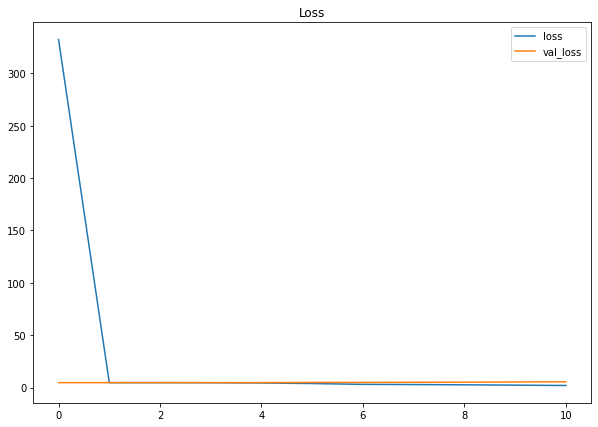

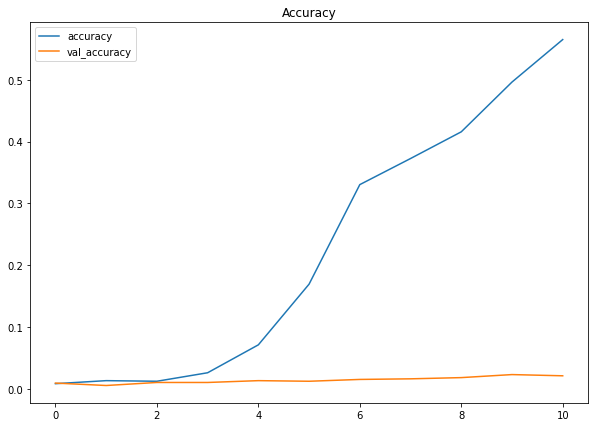

In [39]:
#Plot loss curves
plot_training_curve(history_model_0)

## Model 1: Feature Extraction

### Create data augmentation layer

In [40]:
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = tf.keras.Sequential([
                                         preprocessing.RandomFlip("horizontal"),
                                         preprocessing.RandomRotation(0.2),
                                         preprocessing.RandomZoom(0.2),
                                         preprocessing.RandomHeight(0.2),
                                         preprocessing.RandomWidth(0.2)
])

In [41]:
#Load the base model 
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

16719872/16705208 [==============================] - 0s 0us/step


In [55]:
tf.random.set_seed(42)

#Build the model 
inputs = layers.Input(shape=(224,224,3))
x = data_augmentation(inputs)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

In [56]:
model_1.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 102)               130662    
Total params: 4,180,233
Trainable params: 130,662
Non-trainable params: 4,049,571
_________________________________________________________________


In [57]:
#Compile the model 
model_1.compile(loss="sparse_categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [ ]:
#Fit the model 
history_model_1 = model_1.fit(train_data, 
                              epochs=100,
                              validation_data=val_data,
                              callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, verbose=0),
                                         tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)])

In [53]:
#Evaluate
model_1.evaluate(test_data)

193/193 [==============================] - 23s 118ms/step - loss: 0.5613 - accuracy: 0.8590


[0.5613069534301758, 0.8590014576911926]

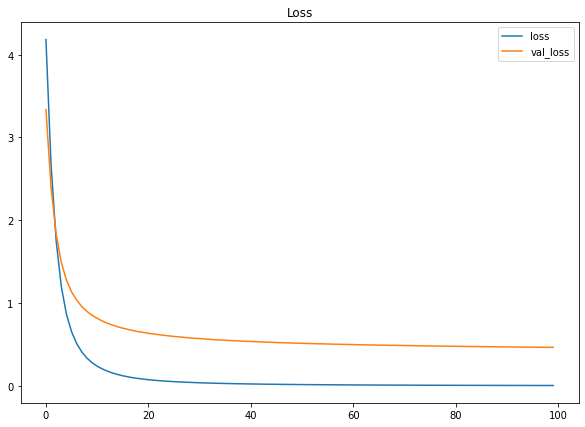

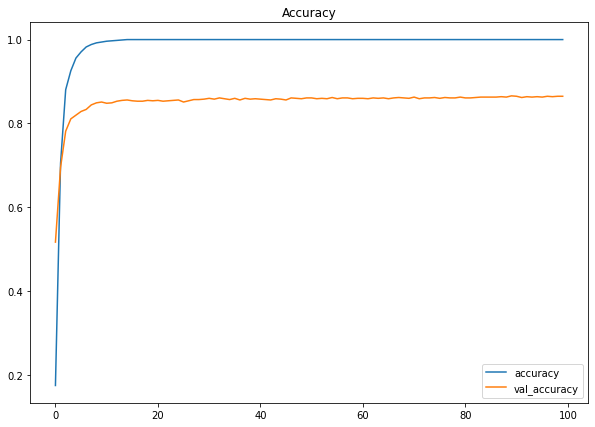

In [54]:
#Plot loss curves
plot_training_curve(history_model_1)